# Optimization Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate how to optimize the number of cloud components in a `TauModel` model.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

from amoeba2 import TauModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.2+0.g883013c.dirty
amoeba2 version: 1.0.0-staging+0.g61de2dc.dirty


## Model Definition and Simulated Data

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_tau = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
tau = {label: rms_tau[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"tau_{label}": SpecData(
        velo_axis[label],
        tau[label],
        rms_tau[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )
    for label in velo_axis.keys()
}

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = TauModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# Evaluate likelihood for given model parameters
# excitation temperature for 1612, 1665, and 1667 MHz
inv_Tex_free = np.array([
    [0.2, -0.2, 0.06], # cloud 0
    [0.06, 0.1, 0.2], # cloud 1
    [0.06, 0.06, 0.1] # cloud 2
])

sim_params = {
    "log10_N_0": np.array([14.0, 14.5, 13.5]),
    "inv_Tex_free": inv_Tex_free,
    "fwhm": np.array([1.2, 1.5, 0.8]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "rms_tau": np.array([0.01, 0.008, 0.012, 0.01]),
}

# Simulate optical depth observations
data = {}
for i, label in enumerate(velo_axis.keys()):
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_tau_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    tau = model.model[f"tau_{label}"].eval(sim_params_label)
    data[f"tau_{label}"] = SpecData(
        velo_axis[label],
        tau,
        sim_params["rms_tau"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )

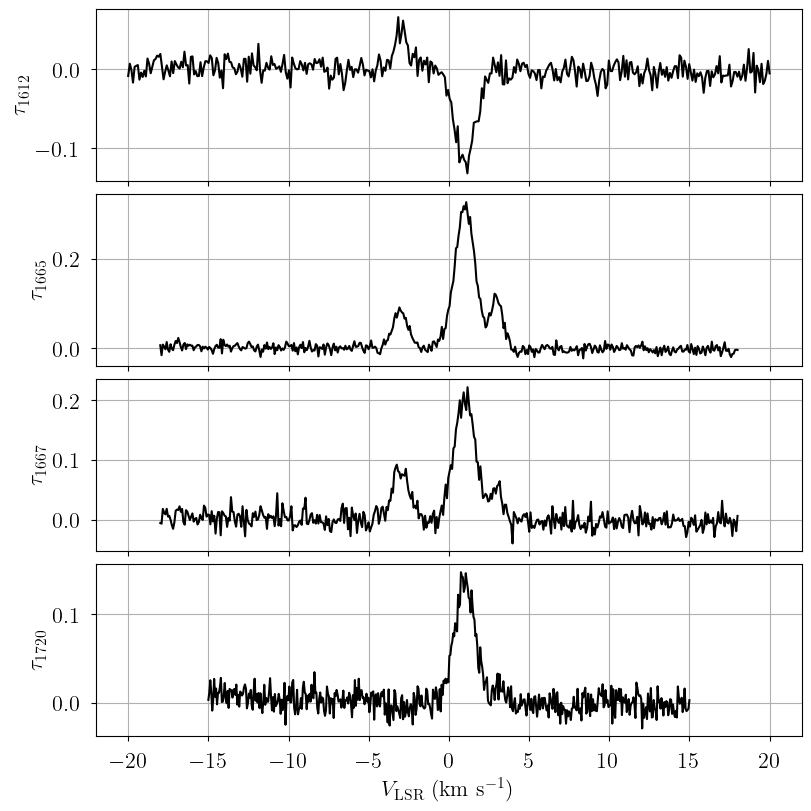

In [3]:
# Plot simulated data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    TauModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=2,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 1.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.9},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 1.621e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = -4,059.7


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -9.804e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 4200
Interrupted at 4,199 [4%]: Average Loss = -4,275.1


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -1.012e+04

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = -4,578.5


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -1.109e+04

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 6700
Interrupted at 6,699 [6%]: Average Loss = -4,652.4


GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = -1.104e+04

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 5800
Interrupted at 5,799 [5%]: Average Loss = -4,598.5


GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = -1.098e+04

Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = -4,578.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, log10_N_0_norm, inv_Tex_free_norm, fwhm_norm, velocity_norm, rms_tau_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 546 seconds.


There were 78 divergences in converged chains.
GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_tau_1612_norm[0],0.128,0.033,0.065,0.189,0.001,0.000,2994.0,2896.0,1.0
baseline_tau_1612_norm[1],-0.406,0.077,-0.552,-0.259,0.001,0.001,5748.0,3087.0,1.0
baseline_tau_1612_norm[2],0.103,0.583,-1.024,1.158,0.011,0.008,3027.0,2810.0,1.0
baseline_tau_1665_norm[0],-0.351,0.012,-0.374,-0.329,0.000,0.000,2679.0,2905.0,1.0
baseline_tau_1665_norm[1],-0.133,0.022,-0.177,-0.093,0.000,0.000,5860.0,2478.0,1.0
baseline_tau_1665_norm[2],0.127,0.218,-0.291,0.524,0.004,0.003,2951.0,2652.0,1.0
baseline_tau_1667_norm[0],-0.352,0.024,-0.401,-0.310,0.000,0.000,3209.0,2972.0,1.0
baseline_tau_1667_norm[1],-0.256,0.048,-0.343,-0.164,0.001,0.000,6176.0,3002.0,1.0
baseline_tau_1667_norm[2],0.286,0.433,-0.516,1.115,0.008,0.006,3119.0,3000.0,1.0
baseline_tau_1720_norm[0],-0.318,0.027,-0.370,-0.270,0.001,0.000,2777.0,3121.0,1.0
